In [1]:
cd /content/drive/MyDrive/URV_and_IRD/URV/paper_need_to_write/GCNs

/content/drive/MyDrive/URV_and_IRD/URV/paper_need_to_write/GCNs


### Understanding Graph Convolutional Networks for Node Classification

- Neural netwok get huge success in the last decade. However, early variants of Neural Networks could only implemented using regular or euclidean data, while a lot data in the real world have underlying graph structures which are non-euclidean. The non-regularity of data structures have led to recent advancements in Graph Neural Networks. 

## Convolution in Graph Neural Networks

- Convolution in GCN is the same as convolution in CNNs. It refers to multiplying the input neurons with a set of weights that are commonly known as filters or kernels. The filters act as a sliding window across the whole image and enable CNNs to learn features from neighboring cells. Within the same layer, the same filter will be used throughout image, this is referred to as wight sharing. For example, using CNN to classify images of cats vs non cats, the same filter will be used in the same layer to detect the nose and the ears of the cat. 

- GCNs perfom similar operations where the model learns the feature by inspecting neighboring nodes. The major difference between CNNs and GNNs is that CNNs are specially built to operate on reglar (Euclidean) structured data, while GNNs are the generalized version of CNNs where the numbers of nodes connections vary and the nodes are unordered (irrelular or non Euclidean structured data).

GCNs themselves can be categorized into 2 major algorithms, **Spatial Graph Convolutional Networks and Spectral Graph Convolutional Networks.** 

### Spectral-based Graph Convolutional Networks

$$H^{[i+1]} = σ(W^{[i]}H^{[i]} + b^{[i]})$$

This is basically equivalent to y = mx + b in linear regression, where m is equivalent to the weights 

x is the input features and b is the bias. 

### Fast Approximate Spectral Graph Convolutional Networks

- The original idea behind Spectral GCN was inspired by signal/wave propagation. We can think of information propogation in Spectral GCN as signal propagation along the nodes. Spectral GCNs make use of the Eigen decomposition of graph Laplacian matrix to implement this method of information propagation. To put it simply, the Eigen-decomposition helps us understand the graph structure, hence, classifying the nodes of the graphs. This is somewhat similar to the basic concept of principal component analysis (PCA) and Linear Discriminant Analysis (LDA) where we use Eigen decomposition to reduce dimensionality and perfom clstering. 

In this approach, we will take into account the adjacency matrix (A) in the forward propagation equation in addition to the node features (os so-called input feautres). A is a matrix that represents the edges or connection betwen the nodes in the forward propagation equation. The insertion of A in the forward pass equation enables the model to learn the feature representations based on nodes connectivity. For the sake of simplicity, the bias b is omitted. The resulting GCN can be seen as the first order approximation of Spectral Graph Convolution in the form of a message passing network where the information is propagated along the neighboring nodes within the graph.

$$H^{[i+1]} = σ(W^{[i]}H^{[i]}A^*)$$

So A* is the normalized version of A. To get better understanding on why we need to normalize A and what happens during forward pass in GCNs let's do an experiment. 



### Building Graph Convolutional Networks

**Initializing the Graph G**

Let's start by building a simple undirected graph (G) using NetworkX. The graph G will consist of 6 nodes and the feautre of each node will correspond to that particular node number. For example, node 1 will have a node feature of 1, node will have a node feature of 2, and so on. To simplify, we are not going to assign edge features in this experiment.

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Graph Info:
 Graph named 'G' with 6 nodes and 7 edges

Graph Nodes:  [(0, {'name': 0}), (1, {'name': 1}), (2, {'name': 2}), (3, {'name': 3}), (4, {'name': 4}), (5, {'name': 5})]


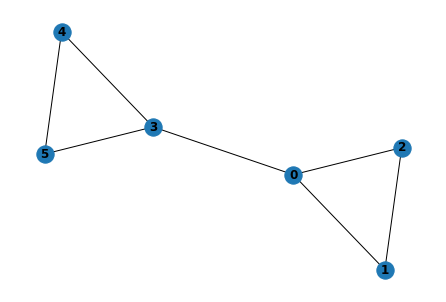

In [3]:
# Initialize the graph
G = nx.Graph(name='G')

# Create nodes
# In this example, the graph will consist of 6 nodes
# Each node is assigned node feature which corresponds to the node name
for i in range(6):
  G.add_node(i, name=i)

# Define the edges and the edges to the graph
edges = [(0,1), (0,2), (1,2), (0,3), (3,4), (3,5), (4,5)]
G.add_edges_from(edges)

# See graph info
print("Graph Info:\n", nx.info(G))

# Inspect the node features
print("\nGraph Nodes: ", G.nodes.data())

#Plot the graph
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

Since we only have 1 graph, this data configuration is an example of a Single mode representation. We will build a GCN that will learn the nodes fratures representation.

Inserting Adjacency Matrix (A) to Forward Pass Equation

The next step is to obtain the adjacency matrix (A) and node features matrix (x) from graph G.

In [4]:
# Get the Adjacency Matrix (A) and Node features matrix (x) as numpy array
A = np.array(nx.attr_matrix(G, node_attr='name')[0])
X = np.array(nx.attr_matrix(G, node_attr='name')[1])
X = np.expand_dims(X, axis=1)

print("Shape of A: ", A.shape)
print("\nShape of X: ", X.shape)
print("\nAdjacency Matrix (A): \n", A)
print("\nNode Feautres matrix (X):\n", X)

Shape of A:  (6, 6)

Shape of X:  (6, 1)

Adjacency Matrix (A): 
 [[0. 1. 1. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1. 0.]]

Node Feautres matrix (X):
 [[0]
 [1]
 [2]
 [3]
 [4]
 [5]]


Now, let's investigate how by inserting A into the forward pass equation adds to richer feature representation of the model. We are going to perform dot product of A and X. 

In [5]:
# Dot product Adjacency Matrix (A) and Node Feautres (X)

AX = np.dot(A, X)
print("Dot product of A and X (AX): \n", AX)

Dot product of A and X (AX): 
 [[6.]
 [2.]
 [1.]
 [9.]
 [8.]
 [7.]]


From the results, it is apparent that AX represents the sum of neighboring nodes features. For example the first row of AX corresponds to the sum of nodes features connected to node 0, which is node 1, 2, and 3. 

## The dot product of adjacency matrix and node features matrix represents the sum of neighboring node features.

- But, if we think about it more, we will realize that while AX sums up the adjacent node features, it does not take into account the features of the node itself.

## Inserting Selh-Loops and Normalizing A

- To address this problem, we now add self-loops to each node of A. Adding self loops is basically a mechanism to connect a node to itself. That being said, all the diagonal elements of Adjacency Matrix A will now become 1 because each node is connected to itself. Let's call A with self-loops added as A_hat and recalculate AX, which is now the dot product of A_hat and X:

In [7]:
# Add self loops
G_self_loops = G.copy()

self_loops = []
for i in range(G.number_of_nodes()):
  self_loops.append((i, i))

G_self_loops.add_edges_from(self_loops)

#Check the edges of G_self_loops after adding the self loops
print("Edges of G with self-loops:\n", G_self_loops.edges)

#Get the adjacency matrix (A) and node features matrix (X) of added
# self-loops graph
A_hat = np.array(nx.attr_matrix(G_self_loops, node_attr='name')[0])
print("Adjacency Matrix of added self-loops G(A_hat):\n", A_hat)

# Calculate the dot product of A_hat and X (AX)
AX = np.dot(A_hat, X)
print('AX:\n', AX)

Edges of G with self-loops:
 [(0, 1), (0, 2), (0, 3), (0, 0), (1, 2), (1, 1), (2, 2), (3, 4), (3, 5), (3, 3), (4, 5), (4, 4), (5, 5)]
Adjacency Matrix of added self-loops G(A_hat):
 [[1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]]
AX:
 [[ 6.]
 [ 3.]
 [ 3.]
 [12.]
 [12.]
 [12.]]


## Now second problem is the elements of AX are not normalized. 
- Similar to data pre-processing for any Neural Networks operation, we need to normalize the features to prevent numerical instabilities and and vanishing/ exploding gradients in order for the model to converge. In GCNs, we normalize our data by calculating the Drgree Matrix (D) and performing dot operation of the inverse of D with AX.

$$Normalized features = D^{-1}AX$$

which we will call DAX in this article. In graph terminology the term degree refers to the number of edges a node is connected to. 


In [8]:
# Get the Degree Matrix of the added self-loops graph

Deg_Mat = G_self_loops.degree()
print('Degree Matrix of added self-loops G (D): ', Deg_Mat)

#Convert the degree matrix to a N x N matrix where N is the number of nodes
D = np.diag([deg for (n, deg) in list(Deg_Mat)])
print("Degree Matrix of added self-loops G as numpy array (D):\n", D)

# Find the inverse of Degree Matrix (D)
D_inv = np.linalg.inv(D)
print("Inverse of D:\n", D_inv)

# Dot product of D and AX for normalization
DAX = np.dot(D_inv, AX)
print('DAX:\n', DAX)

Degree Matrix of added self-loops G (D):  [(0, 5), (1, 4), (2, 4), (3, 5), (4, 4), (5, 4)]
Degree Matrix of added self-loops G as numpy array (D):
 [[5 0 0 0 0 0]
 [0 4 0 0 0 0]
 [0 0 4 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 4 0]
 [0 0 0 0 0 4]]
Inverse of D:
 [[0.2  0.   0.   0.   0.   0.  ]
 [0.   0.25 0.   0.   0.   0.  ]
 [0.   0.   0.25 0.   0.   0.  ]
 [0.   0.   0.   0.2  0.   0.  ]
 [0.   0.   0.   0.   0.25 0.  ]
 [0.   0.   0.   0.   0.   0.25]]
DAX:
 [[1.2 ]
 [0.75]
 [0.75]
 [2.4 ]
 [3.  ]
 [3.  ]]


We can see the impact normalization has on DAX, where the elemetn that corresponds to node 3 has lower values compared to node 4 and 5. but why would node 3 have different values after normalization if it has the same initial value as node 4 and 5?

$$normalizing term = D^{-1}A$$

$$ normalizing term = D^{- \frac{1}{2}}AD^{-\frac{1}{2}} $$

In [9]:
# Symmetrically-normalization
D_half_norm = fractional_matrix_power(D, -0.5)
DADX = D_half_norm.dot(A_hat).dot(D_half_norm).dot(X)
print('DADX:\n', DADX)

DADX:
 [[1.27082039]
 [0.75      ]
 [0.75      ]
 [2.61246118]
 [2.92082039]
 [2.92082039]]


### Adding weights and activation function

We are going to build a 2-layer GCN using ReLU as the activation function. To initialize the weights, we will use random seeds so we can replicate the results. Just keep in mind that the weight initialization cannot be 0. In this experiment, we are going to set 4 neurons for the hidden layer. As we will be plotting the feature representation in 2 dimensions, there will be 2 output neurons

In [12]:
# Initialize the weights
np.random.seed(77777)
n_h = 4 # number of neurons in the hidden layer
n_y = 2 # number of neurons in the output layer
W0 = np.random.randn(X.shape[1], n_h) * 0.01
W1 = np.random.randn(n_h, n_y) * 0.01


# Implement ReLU as activation function
def relu(x):
  return np.maximum(0,x)

# Build GCN layer
# In this function, we implement numpy to simplify
def gcn(A, H, W):
  I = np.identity(A.shape[0]) # Create identity matrix of A
  A_hat = A + I #add self-loop to A
  D = np.diag(np.sum(A_hat, axis=0)) # create degree matrix of A
  D_half_norm = fractional_matrix_power(D, -0.5) # calculate D to the power of -0.5
  eq = D_half_norm.dot(A_hat).dot(D_half_norm).dot(H).dot(W)
  return relu(eq)

# Do forward propogation
H1 = gcn(A, X, W0)
H2 = gcn(A, H1, W1)
print("Features Representation from GCN output:\n", H2)


Features Representation from GCN output:
 [[0.00027758 0.        ]
 [0.00017298 0.        ]
 [0.00017298 0.        ]
 [0.00053017 0.        ]
 [0.00054097 0.        ]
 [0.00054097 0.        ]]


## Plotting the feautures representations

The magic of GCN is that it can learn features representation even without training. Let's visualize the feautres representation after passing through 2 layer GCN

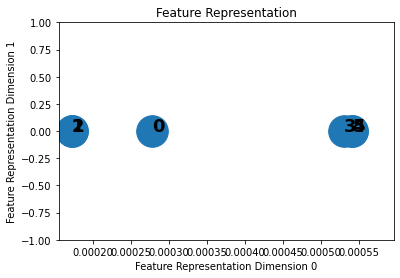

In [13]:
def plot_features(H2):
  #plot the features representation
  x = H2[:,0]
  y = H2[:,1]

  size = 1000

  plt.scatter(x, y, size)
  plt.xlim([np.min(x)*0.9, np.max(x)*1.1])
  plt.ylim([-1, 1])
  plt.xlabel('Feature Representation Dimension 0')
  plt.ylabel('Feature Representation Dimension 1')
  plt.title('Feature Representation')

  for i, row in enumerate(H2):
    str = "{}".format(i)
    plt.annotate(str, (row[0], row[1]), fontsize=18, fontweight='bold')

  plt.show()
plot_features(H2)

From the plot above, it can be clearly seen that there are 2 major groups, where the left group consists of nodes 0, 1, 2, and the right group consists of nodes 3,4,5. We can infer that the GCNs can already learn the feautre representation even without training or backpropagation.

## Key Takeaways

- The term 'convolution' in Graph Convolutional Networks is similar to convolutional neural network in terms of weight sharing. The main difference lies in the data structure, where GCNs are the generalized version of CNN that can work on data with underlying non regular structures. 

- The insertion of Adjacency matrix (A) in the forward pass equation of GCNs enable the model to learn the features of neighboring nodes. This mechanism can be seen as a message passing operation along the nodes within the graph. 

- Renormalization trick is used to normalize the feautres in Fast Approximate Spectral-based Graph Convolutional Networks.

- GCNs can learn features representation even before training.

References:

https://towardsdatascience.com/understanding-graph-convolutional-networks-for-node-classification-a2bfdb7aba7b
